##Module 6.4: Double DQN

We implement a D(ouble) DQN based reinforcement learning system with experiential replay to control the cart-pole environment from AI Gym.

We will also rander and record our environment so we can play back videos of how our system is controlling it.

In this module we will pay attention to:
- Utilizing a double DQN system

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

We will need to install some additional libraries in order to capture and play back video of our reinforcement learning system controlling the environment. We install the libraries now.

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

And here we set up the display for video playback. Don't worry if you see a warning.

Displaying interactive graphics is a headache in Colab, which is why we choose to capture and playback video. If this does not work for you, you can run the code without the video components.

In [0]:
from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1011'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1011'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

Now we set up the cart-pole environments using AI Gym.

In [0]:
from gym.wrappers import TimeLimit
from gym.envs.classic_control import CartPoleEnv
env = TimeLimit(CartPoleEnv(),max_episode_steps=251)
env_long = TimeLimit(CartPoleEnv(),max_episode_steps=5001)

Now we set up our reinforcement learning control system. We will use a class for this.

In [0]:
# Import required libraries
import numpy as np

import matplotlib.pyplot as plt
import random
import time
import glob
import io
import base64

from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.models import Model

from gym.wrappers import Monitor

# Our DDQN Reinforcement Learning Class
class DDQN_Brain:
  # Lots of parameters we can initialize
  def __init__ (
          self,
          epsilon_start=.9,
          epsilon_stop=.1,
          epsilon_decay_episodes=500,
          gamma=.9,
          update_period=20,
          memory_max=10000,
          batch_size=128,
          state_size=4, 
          action_size=2, 
          hidden_size=256
          ):
    self.steps=0
    # We make two DQNs with identical architectures
    self.qNet=self.makeDQN(state_size, action_size, hidden_size)
    self.dqNet=self.makeDQN(state_size, action_size, hidden_size)
    # This will copy the weight values from qNet into dqNet
    self.update_weights()
    self.epsilon=epsilon_start
    self.epsilon_stop=epsilon_stop
    self.epsilon_decay = self.epsilon_stop / self.epsilon
    self.epsilon_decay = self.epsilon_decay ** (1. / float(epsilon_decay_episodes))
    self.gamma=gamma
    self.memory_max=memory_max
    self.memory=[]
    self.batch_size=batch_size
    # These control when we update the double network
    self.replay_count=0
    self.update_period=update_period

  # Here we create the DQN we will use
  def makeDQN(self,state_size, action_size, hidden_size):
    inputs = Input(shape=(state_size, ), name='state')
    h1 = Dense(hidden_size, activation='relu')(inputs)
    h2 = Dense(hidden_size, activation='relu')(h1)
    h3 = Dense(hidden_size, activation='relu')(h2)
    outputs = Dense(action_size, activation='linear', name='action')(h3)
    model = Model(inputs, outputs)
    model.summary()
    optimizer = Adam()
    model.compile(loss='mse', optimizer=optimizer)
    return model

  # This function decays epsilon according to our parameters
  def update_epsilon(self):
    if self.epsilon > self.epsilon_stop:
      self.epsilon *= self.epsilon_decay

  # THIS FUNCTION IS NEW
  # Here we copy the weight values of qNet into dqNet
  def update_weights(self):
    self.dqNet.set_weights(self.qNet.get_weights())

  # We make a decision based on which of our estimated
  # Q-values is highest for a given state
  def decide (self, state):
    Qs = self.qNet.predict(state)
    return np.argmax(Qs)            
  
  # We store a SARS datum in memory.
  def add_to_memory (self,state,action,reward,next_state,done):
    if len(self.memory)==self.memory_max:
      self.memory.pop(0)
    self.memory.append((state,action,reward,next_state,done))

  # THIS FUNCTION HAS BEEN CHANGED
  # This is where we get the q-value for
  # a state for training purposes.
  def get_target_q_value (self,next_state,reward,done):
    if done:
      return reward
    # CHANGE IN DDQN:
    # We use qNet to determine which action to take in
    # the next state.
    action = np.argmax(self.qNet.predict(next_state)[0])
    # But then we use dqNet not qNet to predict q_value 
    # of this action being taken in the next state
    q_value = self.dqNet.predict(next_state)[0,action]
    return reward + self.gamma * q_value    

  # THIS FUNCTION HAS BEEN CHANGED
  # This is where we fetch data from memory and prepare it 
  # as a training batch
  def fetch_batch_from_memory (self):
    # Take a random sample of data store in memory
    memory_sample = random.sample(self.memory, min(self.batch_size,len(self.memory)))
    
    # Construct training batch from memory store
    states = np.zeros((self.batch_size,4))
    q_values = np.zeros((self.batch_size,2))
    i=0
    for state, action, reward, next_state, done in memory_sample:
      # CHANGE IN DDQN:
      # Get q-values for state
      # Note we use dqNet, not qNet
      q_values[i] = self.dqNet.predict(state)[0]      

      # Get current estimate of action's q-value
      q_values[i,action] = self.get_target_q_value(next_state, reward, done)

      # Add state and q-values to batch
      states[i]=state[0]
      i+=1

    # Return the batch ready for training
    return states,q_values

  # THIS FUNCTION HAS BEEN CHANGED
  # This is where we train the network, by 'replaying'
  # data stored in memory
  def replay (self):
    # We only start training once their is at least enough
    # data in memory to create a full batch
    if self.batch_size <= len(self.memory):
      # We prepare the input and target batches
      inputs,targets = self.fetch_batch_from_memory()
      # We adjust the qNet network parameters
      self.qNet.fit(inputs,targets,batch_size=self.batch_size,epochs=1,verbose=0)
      # We decay epsilon leading us to exploit more and explore less.
      self.update_epsilon()
      # CHANGE FOR DDQN
      # Periodically update dqNet by copying in qNet weight values
      self.replay_count+=1
      if self.replay_count > 0 and self.replay_count % self.update_period == 0:
        self.update_weights()

  # Here we determine what action we should take in a given state.
  # Notice that we only explore when training.
  def act (self,env,state,train):
    # Determine if we should explore
    if train and np.random.rand() <= self.epsilon:
      # Make a random action
      return env.action_space.sample()
    # Get action from Q-estimates
    return self.decide(state)
  
  # This runs a complete episode
  def control_episode (self,env,train,render=False):
    # We will track total reward over the episode
    total_reward=0

    # Start new episode
    env.reset()

    # Initial random move to get pole and cart moving
    state, reward, done, _ = env.step(env.action_space.sample())
    state = np.reshape(state, [1, 4])
    
    # The control loop for taking steps
    done = False
    while not done:
      # If we want, we render the environment (create an image)
      if render:
        env.render()

      # Determine action
      action = self.act(env,state,train)

      # Take action, get new state and reward
      next_state, reward, done, _ = env.step(action)
      next_state = np.reshape(next_state, [1, 4])
      
      # Add information to memory
      if train:
        self.add_to_memory(state,action,reward,next_state,done)

      # We could do some training at this point (call replay)
      # but training after each episode works well for this 
      # problem and is much faster!

      # Update local variables
      state=next_state
      total_reward += reward

    # Learn
    if train:
      self.replay()

    # the episode has ended, so record result
    return total_reward

  # Here we control multiple episodes
  def control (self,env,num_episodes,max_steps,train,report_every=100):
    # We track the total rewards in each episode
    final_rewards=np.zeros(num_episodes)
    # We will also time how long things are taking.
    time_start=time.clock()
    
    # We run the desired number of episodes
    for ep in range(num_episodes):
      final_rewards[ep]=self.control_episode(env,train,False)

      # And periodically we print out a report of how we are performing
      if ep!=0 and ep % report_every == 0:
        time_end=time.clock()
        mean_reward=np.sum(final_rewards[ep-report_every:ep+1])/report_every
        print('Episode: {}'.format(ep),
          'Recent Average Rewards: {}'.format(mean_reward),
          'Epsilon: {:.4f}'.format(self.epsilon),
          'Time: {:.2f}'.format(time_end-time_start))
        time_start=time_end
        # We classify the problem as solved if we get an average
        # reward of over 195 during a reporting period.
        # This is actually a little low - the system will learn
        # to balance the pole, but not to keep the cart centered.
        if mean_reward>195:
          print("Problem is considered solved!!!")
          return final_rewards[:ep+1]

    print("Problem was not solved.") 
    return final_rewards

  # This will record and show a video of an episode
  # (if the video display code is run)
  def display_episode(self,env):
    wrapped_env=wrap_env(env)
    self.control_episode(wrapped_env,False,True)
    wrapped_env.close()
    show_video()

# This is a function used in showing videos
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
# This is a function used when recording videos
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


Using TensorFlow backend.


In [0]:
brain=DDQN_Brain()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________

Model: "model_2"
_________________________________________________________________
Layer (type)                 Out

In [0]:
R=brain.control(env,2000,100,True,100)



Episode: 100 Recent Average Rewards: 17.25 Epsilon: 0.5954 Time: 28.34
Episode: 200 Recent Average Rewards: 13.69 Epsilon: 0.3837 Time: 29.37
Episode: 300 Recent Average Rewards: 17.99 Epsilon: 0.2473 Time: 29.69
Episode: 400 Recent Average Rewards: 105.96 Epsilon: 0.1593 Time: 36.21
Episode: 500 Recent Average Rewards: 153.45 Epsilon: 0.1027 Time: 40.55
Episode: 600 Recent Average Rewards: 189.9 Epsilon: 0.0996 Time: 43.65
Episode: 700 Recent Average Rewards: 200.4 Epsilon: 0.0996 Time: 44.70
Problem is considered solved!!!


Let's have a look at the training history. We'll average over results inside the reporting sets intervals to match the numbers above.

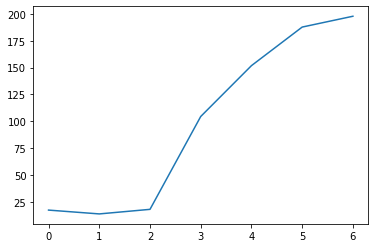

In [0]:
smooth_over=100
R_=[np.mean(R[smooth_over*i:smooth_over*(i+1)]) for i in range(int(R.shape[0]/smooth_over))]
plt.plot(R_)
plt.show()

And we can watch a video of our trained system controlling the cart-pole environment.

In [0]:
brain.display_episode(env_long)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
display.stop()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1011'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1011'] oserror=None return_code=0 stdout="" stderr="" timeout_happened=False>